## Work | Car Fuel Consumption

In [144]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error
from  sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

###  1.  Data preprocessing

In [145]:
# データ読込
df_cfc = pd.read_csv("./car-consume/measurements2.csv")
display(df_cfc.head())
df_cfc.describe()

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas
0,28.0,5.0,26,21.5,12,NaN,E10,0,0,0,45.0,E10
1,12.0,4.2,30,21.5,13,NaN,E10,0,0,0,NaN,NaN
2,11.2,5.5,38,21.5,15,NaN,E10,0,0,0,NaN,NaN
3,12.9,3.9,36,21.5,14,NaN,E10,0,0,0,NaN,NaN
4,18.5,4.5,46,21.5,15,NaN,E10,0,0,0,NaN,NaN


,distance,consume,speed,temp_inside,temp_outside,AC,rain,sun,refill liters
count,388.000000,388.000000,388.000000,376.000000,388.000000,388.000000,388.000000,388.000000,13.000000
mean,19.652835,4.912371,41.927835,21.929521,11.358247,0.077320,0.123711,0.082474,37.115385
std,22.667837,1.033172,13.598524,1.010455,6.991542,0.267443,0.329677,0.275441,8.587282
min,1.300000,3.300000,14.000000,19.000000,-5.000000,0.000000,0.000000,0.000000,10.000000
25%,11.800000,4.300000,32.750000,21.500000,7.000000,0.000000,0.000000,0.000000,37.600000
50%,14.600000,4.700000,40.500000,22.000000,10.000000,0.000000,0.000000,0.000000,38.000000
75%,19.000000,5.300000,50.000000,22.500000,16.000000,0.000000,0.000000,0.000000,39.000000
max,216.100000,12.200000,90.000000,25.500000,31.000000,1.000000,1.000000,1.000000,45.000000


In [146]:
# 欠損値の有無
print(df_carconsume.isnull().any())

distance         False
consume          False
speed            False
temp_inside       True
temp_outside     False
specials          True
gas_type         False
AC               False
rain             False
sun              False
refill liters     True
refill gas        True
dtype: bool


In [147]:
# 欠損値補完：temp_inside
df_cfc['temp_inside'] = df_cfc['temp_inside'].fillna(df_cfc['temp_inside'].mean())

In [148]:
# ダミー変数：gas_type
df_dummy = pd.get_dummies(df_cfc['gas_type'])
df_cfc = pd.concat([df_cfc, df_dummy], axis=1)
display(df_cfc.head())

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas,E10,SP98
0,28.0,5.0,26,21.5,12,NaN,E10,0,0,0,45.0,E10,1,0
1,12.0,4.2,30,21.5,13,NaN,E10,0,0,0,NaN,NaN,1,0
2,11.2,5.5,38,21.5,15,NaN,E10,0,0,0,NaN,NaN,1,0
3,12.9,3.9,36,21.5,14,NaN,E10,0,0,0,NaN,NaN,1,0
4,18.5,4.5,46,21.5,15,NaN,E10,0,0,0,NaN,NaN,1,0


In [149]:
df_cfc.count()

distance         388
consume          388
speed            388
temp_inside      388
temp_outside     388
specials          93
gas_type         388
AC               388
rain             388
sun              388
refill liters     13
refill gas        13
E10              388
SP98             388
dtype: int64

- 'refill liters', 'refill gas' はデータ不足により説明変数から除外
- 'specials' は'AC', 'rain', 'sun' で表現されているため説明変数から除外
- 'gas_type' からダミー変数を生成(E10, SP98)

### 2. Graph

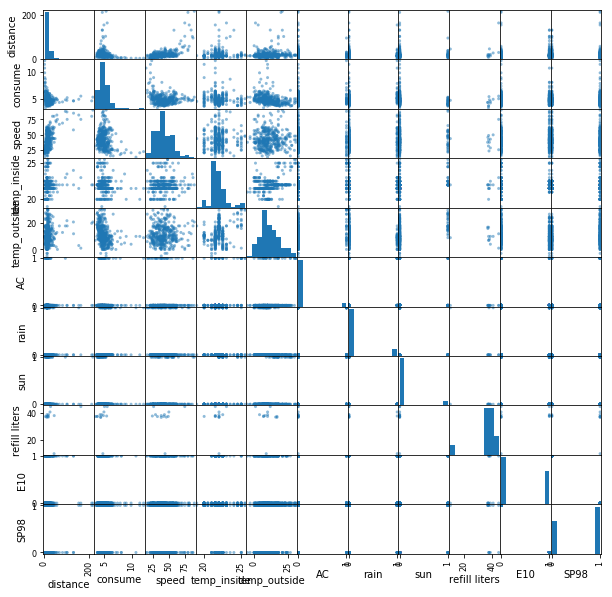

In [150]:
# 散布図行列
pd.plotting.scatter_matrix(df_cfc, figsize=(10,10))
plt.show()

In [151]:
# 相関係数
df_cfc.corr()

,distance,consume,speed,temp_inside,temp_outside,AC,rain,sun,refill liters,E10,SP98
distance,1.000000,-0.128967,0.562299,0.075178,0.088175,-0.025738,-0.019791,0.081120,0.132852,0.053411,-0.053411
consume,-0.128967,1.000000,-0.227866,-0.160623,-0.320811,0.096591,0.248118,-0.170667,0.100868,0.015327,-0.015327
speed,0.562299,-0.227866,1.000000,0.059293,0.015411,-0.035408,0.009489,0.081618,0.049673,0.097360,-0.097360
temp_inside,0.075178,-0.160623,0.059293,1.000000,0.359500,0.297376,-0.036937,0.242248,0.034128,-0.010198,0.010198
temp_outside,0.088175,-0.320811,0.015411,0.359500,1.000000,0.167562,-0.186315,0.346903,-0.084867,-0.148705,0.148705
AC,-0.025738,0.096591,-0.035408,0.297376,0.167562,1.000000,0.242915,0.088598,NaN,-0.105285,0.105285
rain,-0.019791,0.248118,0.009489,-0.036937,-0.186315,0.242915,1.000000,-0.112650,-0.494501,-0.060328,0.060328
sun,0.081120,-0.170667,0.081618,0.242248,0.346903,0.088598,-0.112650,1.000000,NaN,-0.022761,0.022761
refill liters,0.132852,0.100868,0.049673,0.034128,-0.084867,NaN,-0.494501,NaN,1.000000,0.238081,-0.238081
E10,0.053411,0.015327,0.097360,-0.010198,-0.148705,-0.105285,-0.060328,-0.022761,0.238081,1.000000,-1.000000


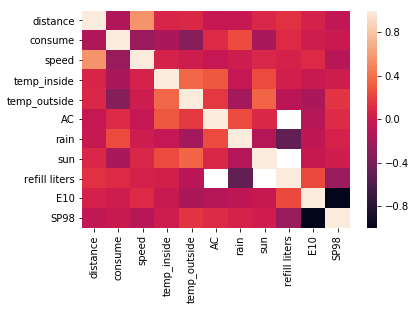

In [153]:
# ヒートマップ
sns.heatmap(df_cfc.corr())
plt.show()

- 説明変数 'distance' と 'speed' について、比較的相関関係が高い (0.56)
- 上記以外に相関関係が高い組み合わせは見受けられない

### 3. Model

In [175]:
#　線形回帰
y = df_cfc["consume"].values
X = df_cfc[['distance', 'speed', 'temp_inside', 'temp_outside', 'AC', 'rain', 'sun', 'E10', 'SP98']].values
# X = df_cfc[['speed', 'temp_inside', 'temp_outside', 'AC', 'rain', 'sun', 'E10', 'SP98']].values
# X = df_cfc[['distance', 'temp_inside', 'temp_outside', 'AC', 'rain', 'sun', 'E10', 'SP98']].values
regr = LinearRegression(fit_intercept=True)
regr.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

- 説明変数: 'distance', 'speed', 'temp_inside', 'temp_outside', 'AC', 'rain', 'sun', 'E10', 'SP98'
- 目的変数: 'consume'

### 4. Evaluation

In [174]:
y_pred = regr.predict(X)

mse = mean_squared_error(y, y_pred) 
print("MSE = %s"%round(mse,3) )  
mae = mean_absolute_error(y, y_pred) 
print("MAE = %s"%round(mae,3) )
rmse = np.sqrt(mse)
print("RMSE = %s"%round(rmse, 3) )

MSE = 0.845
MAE = 0.618
RMSE = 0.919


- 説明変数から 'distance' を除外した場合は、精度に変化は見られない
- 説明変数から 'speed' を除外した場合にMSE,RMSEが多少上昇する。MAEは低下する